In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils.class_weight import compute_class_weight
from skimage import io
import timeit
from sklearn.metrics import (accuracy_score, balanced_accuracy_score, classification_report, confusion_matrix)
import cv2
import shutil
from sklearn.model_selection import train_test_split


In [2]:
import tensorflow as tf
print(tf.__version__)
print(tf.test.is_built_with_cuda())
print(tf.config.list_physical_devices('GPU'))

2.9.0
True
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
def get_classes(data_path, classes, data):
    print(f"----{data}----")
    images={}
    count=0

    for i in range(len(classes)):
        x=""
        if i==0:
          x="Benign"
        elif i==1:
          x="Malignant"
        elif i==2:
          x="Normal"
        imgs=os.listdir(os.path.join(data_path, x))
        images[i]=imgs
        count+=len(imgs)

    for k, v in images.items():
        print(
            f"Grade {k}-{classes[k]}: {len(v)} images, {round((len(v)*100)/count, 2)}%"
        )

    return images

def plot_classes(dict_classes, data_path, classes, data):
    for k, v in dict_classes.items():
        print(f"{data}-{classes[k]}")
        plt.figure(figsize=(10, 25))
        x=""
        if k==0:
          x="Benign"
        elif k==1:
          x="Malignant"
        elif k==2:
          x="Normal"
        for i in range(5):
            img_path=os.path.join(data_path, x, v[i])
            img=tf.keras.preprocessing.image.load_img(img_path)
            plt.subplot(1, 5, 1+i, xticks=[], yticks=[])
            plt.imshow(img)
            plt.title(f"{x}")
        plt.show()

In [4]:
os.listdir(r"C:\Users\jason\final_project\input\lung-cancer-dataset-1\Lung Cancer Dataset 1")
base_dir = r"C:\Users\jason\final_project\input\lung-cancer-dataset-1\Lung Cancer Dataset 1"
class_names=['Benign', 'Malignant', 'Normal']
working_data_path = '/working/dataset'

# Copy the dataset to a writable directory
if not os.path.exists(working_data_path):
    shutil.copytree(base_dir, working_data_path)

train_split = '/working/dataset/train_split'  # New train data path (70%)
valid_split = '/working/dataset/valid_split'  # New validation data path (10%)
test_split = '/working/dataset/test_split'  # New test data path (20%)
os.makedirs(train_split, exist_ok=True)
os.makedirs(valid_split, exist_ok=True)
os.makedirs(test_split, exist_ok=True)

categories = os.listdir(base_dir)

In [5]:
# Split and copy data
for category in categories:
    category_path = os.path.join(base_dir, category)
    images = os.listdir(category_path)
    
    # Split the images into 70% train and 30% remaining (for test and validation)
    train_images, remaining_images = train_test_split(images, test_size=0.3, random_state=42)
    
    # Split remaining images into 2/3 test (20%) and 1/3 validation (10%)
    test_images, valid_images = train_test_split(remaining_images, test_size=1/3, random_state=42)
    
    # Create category subdirectories in the new train and valid directories
    train_category_path = os.path.join(train_split, category)
    test_category_path = os.path.join(test_split, category)
    valid_category_path = os.path.join(valid_split, category)
    os.makedirs(train_category_path, exist_ok=True)
    os.makedirs(test_category_path, exist_ok=True)
    os.makedirs(valid_category_path, exist_ok=True)
    
    # Copy images to the respective folders
    for img in train_images:
        shutil.copy(os.path.join(category_path, img), os.path.join(train_category_path, img))
    for img in test_images:
        shutil.copy(os.path.join(category_path, img), os.path.join(test_category_path, img))
    for img in valid_images:
        shutil.copy(os.path.join(category_path, img), os.path.join(valid_category_path, img))

print("Data split complete!")

Data split complete!


In [6]:
train_data=get_classes(train_split, class_names, 'Train')
test_data=get_classes(test_split, class_names, 'Test')
valid_data=get_classes(valid_split, class_names, 'Valid')

----Train----
Grade 0-Benign: 110 images, 13.87%
Grade 1-Malignant: 392 images, 49.43%
Grade 2-Normal: 291 images, 36.7%
----Test----
Grade 0-Benign: 24 images, 10.96%
Grade 1-Malignant: 112 images, 51.14%
Grade 2-Normal: 83 images, 37.9%
----Valid----
Grade 0-Benign: 12 images, 10.81%
Grade 1-Malignant: 57 images, 51.35%
Grade 2-Normal: 42 images, 37.84%


Train data-Benign


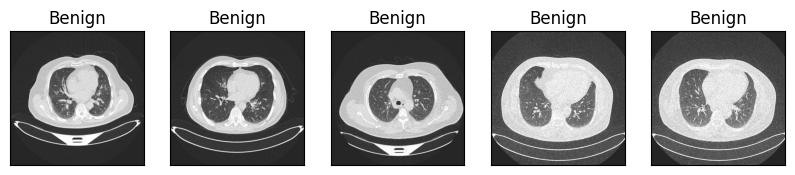

Train data-Malignant


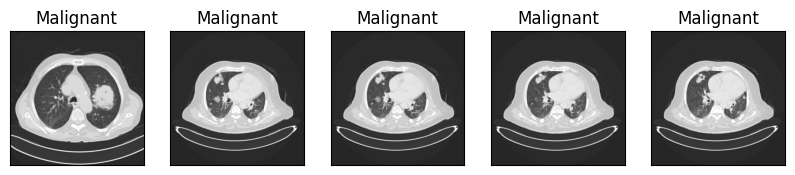

Train data-Normal


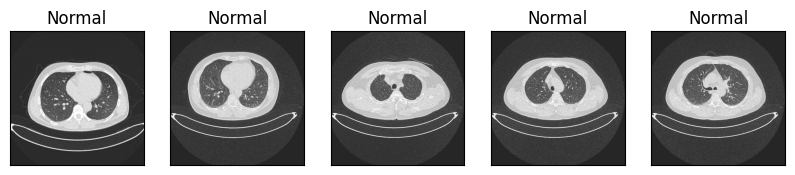

In [7]:
plot_classes(train_data, train_split, class_names, 'Train data')

In [8]:
def get_plot_loss_acc(model, model_name):
    fig=plt.figure()
    plt.subplot(2, 1, 1)
    plt.plot(model.history.history["loss"])
    plt.plot(model.history.history["val_loss"])
    plt.title(f"{model_name} \n\n model loss")
    plt.ylabel("loss")
    plt.xlabel("epoch")
    plt.legend(["train", "valid"], loc="upper right")

    plt.subplot(2, 1, 2)
    plt.plot(model.history.history["accuracy"])
    plt.plot(model.history.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "valid"], loc="lower right")

    plt.tight_layout()

def compute_confusion_matrix(ytrue, ypred, class_names, model_name):
    cm=confusion_matrix(
        y_true=ytrue.labels,
        y_pred=np.argmax(ypred, axis=1),
    )
    cmn=cm.astype("float")/cm.sum(axis=1)[:, np.newaxis]
    plt.subplots(figsize=(6, 5))
    sns.heatmap(
        cmn,
        annot=True,
        fmt=".2f",
        cmap="Purples",
        xticklabels=class_names,
        yticklabels=class_names,
    )
    plt.title(f"Confusion Matrix - {model_name}")
    plt.ylabel("Actual")
    plt.xlabel("Predicted")
    plt.show(block=False)

def get_evaluate(data, name, model):
    score_model=model.evaluate(data, verbose=1)
    print(f"{name} loss: {score_model[0]: .2f}")
    print(f"{name} accuracy: {score_model[1]: .2f}")

def get_predict(data, model):
    predict_model=model.predict(data)
    return predict_model

def get_metrics(y_test, y_pred, model_name):
    acc=accuracy_score(y_test, y_pred)
    bal_acc=balanced_accuracy_score(y_test, y_pred)

    print(f"Accuracy Score - {model_name}: {acc: .2f}")
    print(f"Balanced Accuracy Score - {model_name}: {bal_acc: .2f}")
    print("\n")

    print(classification_report(y_test, y_pred))

In [33]:
model_name="DENSE U-Net"

target_size=(224, 224)
epochs=150
batch_size=50
img_shape=(224, 224, 3)

save_model_ft=os.path.join('models', f'model_{model_name}_ft.hdf5')

In [10]:
def apply_clahe(image):
    # Convert the image to grayscale (8-bit unsigned, single-channel)
    gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    # Ensure the image is in CV_8UC1 format
    if gray_image.dtype != np.uint8:
        gray_image = np.uint8(gray_image)

    # Apply CLAHE to the grayscale image
    clahe = cv2.createCLAHE(clipLimit=40.0, tileGridSize=(8, 8))
    enhanced_image = clahe.apply(gray_image)

    # Convert the enhanced grayscale image back to RGB color space
    enhanced_rgb = cv2.cvtColor(enhanced_image, cv2.COLOR_GRAY2RGB)

    return enhanced_rgb

In [11]:
aug_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=lambda x: apply_clahe(x),
    horizontal_flip=True,
    brightness_range=[0.3, 0.8],
    width_shift_range=[-50, 0, 50, 30, -30],
    zoom_range=0.1,
    fill_mode="nearest",
)

noaug_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=lambda x: apply_clahe(x),
)

Found 793 images belonging to 3 classes.


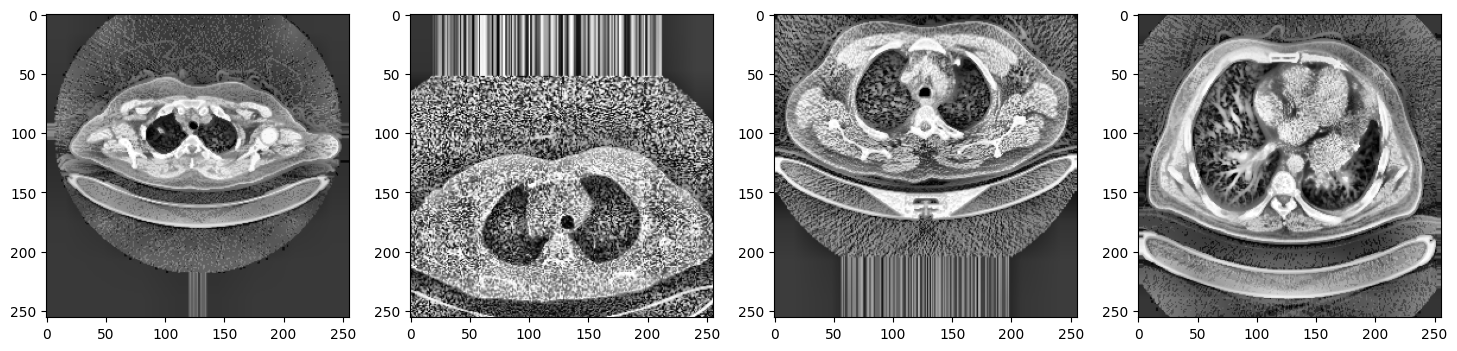

In [12]:
imagegen=aug_datagen.flow_from_directory(train_split, batch_size=1)
fig, rows=plt.subplots(nrows=1, ncols=4, figsize=(18, 18))
for row in rows:
    row.imshow(next(imagegen)[0][0].astype('uint8'))
plt.show()

In [13]:
# 训练数据生成器
train_generator = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
).flow_from_directory(
    train_split,
    target_size=(img_shape[0], img_shape[1]),
    batch_size=batch_size,
    class_mode='sparse',
    shuffle=True
)

# 验证数据生成器
valid_generator = ImageDataGenerator(
    rescale=1./255
).flow_from_directory(
    valid_split,
    target_size=(img_shape[0], img_shape[1]),
    batch_size=batch_size,
    class_mode='sparse',
    shuffle=False
)

Found 793 images belonging to 3 classes.
Found 111 images belonging to 3 classes.


In [14]:
y_train = train_generator.labels
y_val = valid_generator.labels

In [15]:
unique, counts = np.unique(y_train, return_counts=True)
print("Train: ", dict(zip(unique, counts)))

class_weights = compute_class_weight(
    class_weight="balanced", classes=np.unique(y_train), y=y_train
)
train_class_weights = dict(enumerate(class_weights))
print(train_class_weights)

Train:  {0: 110, 1: 392, 2: 291}
{0: 2.403030303030303, 1: 0.6743197278911565, 2: 0.9083619702176403}


In [16]:
classes = np.unique(y_train)

# Callbacks
early = tf.keras.callbacks.EarlyStopping(
            monitor='val_loss', min_delta=0.01, patience=8,
            restore_best_weights=True
        )
plateau = tf.keras.callbacks.ReduceLROnPlateau(
                monitor='loss', factor=0.1, min_delta=0.01,
                min_lr=1e-10, patience=4, mode='auto'
            )

In [17]:
import tensorflow as tf
from tensorflow.keras import layers, Model

def create_dense_block(x, blocks, growth_rate):
    for i in range(blocks):
        conv = layers.Conv2D(growth_rate, 3, padding='same')(x)
        conv = layers.BatchNormalization()(conv)
        conv = layers.Activation('relu')(conv)
        x = layers.Concatenate()([x, conv])
    return x

def create_dense_unet_classifier(input_shape, num_classes=3):
    # 输入层
    inputs = layers.Input(input_shape)
    
    # 编码器路径（降低通道数）
    conv1 = layers.Conv2D(32, 3, padding='same')(inputs)  # 64 → 32
    conv1 = layers.BatchNormalization()(conv1)
    conv1 = layers.Activation('relu')(conv1)
    dense1 = create_dense_block(conv1, 2, 16)  # (4 → 2 blocks), (32 → 16 filters)
    pool1 = layers.MaxPooling2D()(dense1)
    
    dense2 = create_dense_block(pool1, 4, 16)  # (6 → 4 blocks)
    pool2 = layers.MaxPooling2D()(dense2)
    
    # 中间特征提取
    dense3 = create_dense_block(pool2, 6, 16)  # (8 → 6 blocks)
    
    # CNN分类头（降低参数量）
    conv_class = layers.Conv2D(128, 3, padding='same')(dense3)  # 256 → 128
    conv_class = layers.BatchNormalization()(conv_class)
    conv_class = layers.Activation('relu')(conv_class)
    
    gap = layers.GlobalAveragePooling2D()(conv_class)
    dense_class = layers.Dense(256, activation='relu')(gap)  # 512 → 256
    dropout = layers.Dropout(0.3)(dense_class)  # 0.5 → 0.3
    outputs = layers.Dense(num_classes, activation='softmax')(dropout)
    
    model = Model(inputs, outputs)
    return model


In [18]:
# 创建模型
model = create_dense_unet_classifier(img_shape)

# 编译模型
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=3e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# 打印模型结构
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 224, 224, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 224, 224, 32  128        ['conv2d[0][0]']                 
 alization)                     )                                                             

In [19]:
# 回调函数
early = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0.01,
    patience=10,
    restore_best_weights=True
)

plateau = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=5,
    min_lr=1e-6
)

# 训练模型
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=valid_generator,
    callbacks=[early, plateau],
    class_weight=train_class_weights,
    verbose=1
)

Epoch 1/150
16/16 [==============================] - 31s 1s/step - loss: 0.9806 - accuracy: 0.5372 - val_loss: 0.9922 - val_accuracy: 0.5946 - lr: 3.0000e-04
Epoch 2/150
16/16 [==============================] - 12s 698ms/step - loss: 0.7368 - accuracy: 0.7011 - val_loss: 2.1070 - val_accuracy: 0.5135 - lr: 3.0000e-04
Epoch 3/150
16/16 [==============================] - 11s 673ms/step - loss: 0.6500 - accuracy: 0.7604 - val_loss: 4.2203 - val_accuracy: 0.5135 - lr: 3.0000e-04
Epoch 4/150
16/16 [==============================] - 11s 670ms/step - loss: 0.6101 - accuracy: 0.7024 - val_loss: 6.3364 - val_accuracy: 0.5135 - lr: 3.0000e-04
Epoch 5/150
16/16 [==============================] - 11s 658ms/step - loss: 0.5840 - accuracy: 0.7427 - val_loss: 7.7202 - val_accuracy: 0.5135 - lr: 3.0000e-04
Epoch 6/150
16/16 [==============================] - 11s 639ms/step - loss: 0.5552 - accuracy: 0.7541 - val_loss: 8.0773 - val_accuracy: 0.5135 - lr: 3.0000e-04
Epoch 7/150
16/16 [==================

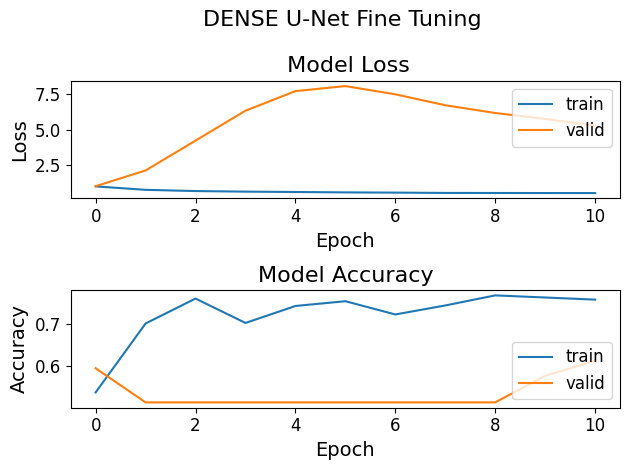

In [34]:
get_plot_loss_acc(model, f"{model_name} Fine Tuning")

In [24]:
get_evaluate(train_generator, "Train", model)

16/16 [==============================] - 7s 397ms/step - loss: 1.0281 - accuracy: 0.4943
Train loss:  1.03
Train accuracy:  0.49


In [25]:
get_evaluate(valid_generator, "Valid", model)

3/3 [==============================] - 1s 129ms/step - loss: 0.9922 - accuracy: 0.5946
Valid loss:  0.99
Valid accuracy:  0.59


In [26]:
predict_model_ft = get_predict(valid_generator, model)

get_metrics(
    valid_generator.labels,
    y_pred=np.argmax(predict_model_ft, axis=1),
    model_name=model_name,
)

3/3 [==============================] - 1s 505ms/step
Accuracy Score - EfficientNet:  0.59
Balanced Accuracy Score - EfficientNet:  0.40


              precision    recall  f1-score   support

           0       0.00      0.00      0.00        12
           1       0.56      1.00      0.72        57
           2       0.90      0.21      0.35        42

    accuracy                           0.59       111
   macro avg       0.49      0.40      0.36       111
weighted avg       0.63      0.59      0.50       111



d:\anaconda3\envs\cancer\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\anaconda3\envs\cancer\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\anaconda3\envs\cancer\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


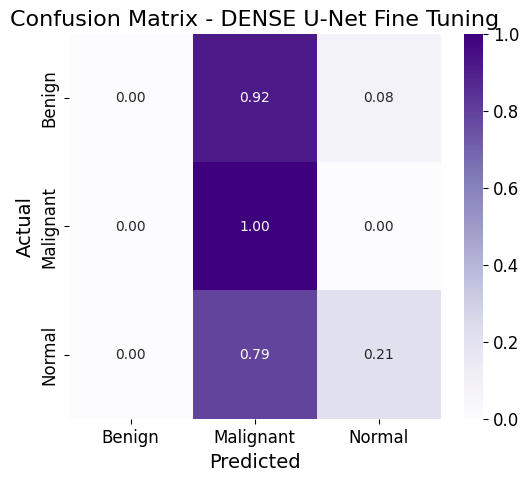

In [35]:
compute_confusion_matrix(
    valid_generator, predict_model_ft, class_names, f"{model_name} Fine Tuning"
)